<a href="https://colab.research.google.com/github/ASN-Lab/Big-Data/blob/main/BigData_Final_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Final Project — GitHub Commits Dataset


## 1. Install Java & PySpark (Colab)

In [1]:
# Install Java and pyspark (run once per Colab runtime)
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq
!pip install -q pyspark==3.5.2 findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
print("Java and pyspark installed.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package openjdk-11-jre-headless:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../openjdk-11-jre-headless_11.0.29+7-1ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
Selecting previously unselected package openjdk-11-jdk-headless:amd64.
Preparing to unpack .../openjdk-11-jdk-headless_11.0.29+7-1ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-11-jdk-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid

## 2. Mount Google Drive and set CSV path

In [3]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/Responsi_UAS_Big_Data/full.csv"
import os
print("File exists:", os.path.exists(csv_path))

Mounted at /content/drive
File exists: True


## 3. Initialize SparkSession

In [25]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# Konfigurasi memory untuk spark
conf = SparkConf().setAll([("spark.ui.showConsoleProgress","false"), ("spark.kryoserializer.buffer.max", "2g")])
spark = SparkSession.builder.appName("BigData_Final_GithubCommits").config("spark.driver.memory", "6g").config("spark.executor.memory", "2g").config("spark.driver.maxResultSize", "1g").config(conf=conf).getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("Spark initialized:", spark.sparkContext.appName)

Spark initialized: BigData_Final_GithubCommits


## 4. Load CSV into Spark DataFrame

In [6]:
df = spark.read.option("header", True).option("escape", "\"").option("multiLine", False).csv(csv_path)
print("Schema:")
df.printSchema()

print("Rows (count):", df.count())

Schema:
root
 |-- commit: string (nullable = true)
 |-- author: string (nullable = true)
 |-- date: string (nullable = true)
 |-- message: string (nullable = true)
 |-- repo: string (nullable = true)

Rows (count): 32467868


## 5. Identify missing values

In [7]:
from pyspark.sql.functions import col, when, sum as _sum
null_counts = df.select([_sum(when(col(c).isNull() | (col(c) == ''), 1).otherwise(0)).alias(c) for c in df.columns])
null_counts.show()

+------+--------+--------+--------+--------+
|commit|  author|    date| message|    repo|
+------+--------+--------+--------+--------+
|     0|21285373|27477963|27949912|31637941|
+------+--------+--------+--------+--------+



## 6. Cleaning & Feature Creation

In [8]:
from pyspark.sql.functions import when, trim, lower, length, to_timestamp

df = df.withColumn("message", when(col("message").isNull() | (col("message") == ''), "No message").otherwise(col("message")))
df = df.withColumn("date_parsed", to_timestamp(col("date")))
df = df.withColumn("repo", lower(trim(col("repo"))))
df = df.withColumn("author", trim(col("author")))
df = df.withColumn("msg_length", length(col("message")).cast("int"))

df.select("commit","author","repo","date_parsed","msg_length").show(5, truncate=False)

+----------------------------------------+---------------------------------------------------------+-----------------+-----------+----------+
|commit                                  |author                                                   |repo             |date_parsed|msg_length|
+----------------------------------------+---------------------------------------------------------+-----------------+-----------+----------+
|692bba578efb5e305c9b116568e5aad75b3fdbb3|Mortada Mehyar <mortada@users.noreply.github.com>        |pandas-dev/pandas|NULL       |62        |
|855696cde0ef5d80a7d4bd3f6a2940c5a2fecb3f|Patrick Hoefler <61934744+phofl@users.noreply.github.com>|pandas-dev/pandas|NULL       |40        |
|eaaefd140289a5103679ac6748567f724c7be56a|attack68 <24256554+attack68@users.noreply.github.com>    |pandas-dev/pandas|NULL       |48        |
|aab87997058f3c74ba70286620ebe792ee4ef169|attack68 <24256554+attack68@users.noreply.github.com>    |pandas-dev/pandas|NULL       |69        |
|9c43c

## 7. Deduplication

In [9]:
before = df.count()
df = df.dropDuplicates(["commit"])
after = df.count()
print(f"Rows before: {before}, after dedup: {after}")

Rows before: 32467868, after dedup: 22238155


## 8. Outlier detection and capping on msg_length

In [10]:
quantiles = df.approxQuantile("msg_length", [0.25,0.5,0.75], 0.01)
Q1,Q2,Q3 = quantiles
IQR = Q3 - Q1
lower = max(0, Q1 - 1.5*IQR)
upper = Q3 + 1.5*IQR
print("Q1,Q2,Q3:", Q1,Q2,Q3, "IQR:", IQR, "bounds:", lower, upper)

from pyspark.sql.functions import when
df = df.withColumn("msg_length_capped", when(col("msg_length") < lower, lower).when(col("msg_length") > upper, upper).otherwise(col("msg_length")))
df.select("msg_length","msg_length_capped").show(5)

Q1,Q2,Q3: 10.0 10.0 10.0 IQR: 0.0 bounds: 10.0 10.0
+----------+-----------------+
|msg_length|msg_length_capped|
+----------+-----------------+
|        10|             10.0|
|        51|             10.0|
|        49|             10.0|
|        43|             10.0|
|        24|             10.0|
+----------+-----------------+
only showing top 5 rows



## 9. Normalization (Min-Max) on msg_length_capped

In [11]:
min_val = df.agg({"msg_length_capped":"min"}).collect()[0][0]
max_val = df.agg({"msg_length_capped":"max"}).collect()[0][0]
min_v = float(min_val); max_v = float(max_val)
df = df.withColumn("msg_length_norm", (col("msg_length_capped") - min_v) / (max_v - min_v))
df.select("msg_length_capped","msg_length_norm").show(5)

+-----------------+---------------+
|msg_length_capped|msg_length_norm|
+-----------------+---------------+
|             10.0|           NULL|
|             10.0|           NULL|
|             10.0|           NULL|
|             10.0|           NULL|
|             10.0|           NULL|
+-----------------+---------------+
only showing top 5 rows



## 10. Extract date parts

In [12]:
from pyspark.sql.functions import year, month, dayofmonth, date_format
df = df.withColumn("year", year(col("date_parsed"))).withColumn("month", month(col("date_parsed"))).withColumn("day", dayofmonth(col("date_parsed"))).withColumn("weekday", date_format(col("date_parsed"), "E"))
df.select("date_parsed","year","month","weekday").show(5)

+-----------+----+-----+-------+
|date_parsed|year|month|weekday|
+-----------+----+-----+-------+
|       NULL|NULL| NULL|   NULL|
|       NULL|NULL| NULL|   NULL|
|       NULL|NULL| NULL|   NULL|
|       NULL|NULL| NULL|   NULL|
|       NULL|NULL| NULL|   NULL|
+-----------+----+-----+-------+
only showing top 5 rows



## 11. Aggregations (top repos, authors, commits per month)

In [13]:
repo_counts = df.groupBy("repo").count().orderBy(col("count").desc()).limit(20)
author_counts = df.groupBy("author").count().orderBy(col("count").desc()).limit(20)
commits_per_month = df.groupBy("year","month").count().orderBy("year","month")

repo_counts.show(20, truncate=False)
author_counts.show(20, truncate=False)
commits_per_month.show(20, truncate=False)

+-------------------------+--------+
|repo                     |count   |
+-------------------------+--------+
|NULL                     |21443865|
|openbsd/src              |103913  |
|rust-lang/rust           |77692   |
|microsoft/vscode         |65566   |
|freebsd/freebsd-src      |64140   |
|python/cpython           |64042   |
|apple/swift              |45804   |
|kubernetes/kubernetes    |41491   |
|rstudio/rstudio          |29388   |
|opencv/opencv            |25793   |
|microsoft/typescript     |22027   |
|scikit-learn/scikit-learn|20097   |
|pandas-dev/pandas        |18892   |
|tensorflow/tensorflow    |17810   |
|jupyterlab/jupyterlab    |17229   |
|scipy/scipy              |15811   |
|postgres/postgres        |15643   |
|matplotlib/matplotlib    |15123   |
|torvalds/linux           |14647   |
|ipython/ipython          |14304   |
+-------------------------+--------+

+-------------------------------------------------------------------------+--------+
|author                   

## 12. Top words in messages (distributed word count)

In [14]:
from pyspark.sql.functions import split, explode, regexp_replace, lower
stopwords = ["the","and","to","a","for","of","in","on","is","no","fix","add","update","use","by","this","that"]
words = df.select(explode(split(regexp_replace(lower(col("message")), r'[^a-z0-9\\s]', ' '), r'\\s+')).alias("word"))
words_filtered = words.filter((col("word") != "") & (~col("word").isin(stopwords)))
top_words = words_filtered.groupBy("word").count().orderBy(col("count").desc()).limit(30)
top_words.show(30, truncate=False)

+-----------------------------------------------------------------+--------+
|word                                                             |count   |
+-----------------------------------------------------------------+--------+
|no message                                                       |17801350|
|merge remote tracking branch  origin master  into master next    |12765   |
|daily bump                                                       |8459    |
|update  deps git                                                 |8302    |
|sync                                                             |5159    |
| multiple changes                                                |3589    |
|webcore                                                          |2319    |
|regen                                                            |2084    |
| unsigned int                                                    |1980    |
|go  update generated wrapper functions for tensorflow ops        |1709    |

## 13. Sampling to pandas for visualization

In [16]:
sample_frac = 0.001
sampled = df.sample(withReplacement=False, fraction=sample_frac, seed=42)
print("Sampled rows:", sampled.count())

from pyspark.sql.functions import col, when, year, month, dayofmonth, date_format

# pembersihan 'date_parsed' di DataFrame sampel berdasarkan kolom year
sampled = sampled.withColumn("date_parsed", \
                   when((year(col("date_parsed")).isNotNull()) & \
                        ((year(col("date_parsed")) < 1970) | (year(col("date_parsed")) > 2050)), None) \
                   .otherwise(col("date_parsed")))

# Re-extract kolom year, month, day, weekday dari hasil 'date_parsed'
sampled = sampled.withColumn("year", year(col("date_parsed")))\
                 .withColumn("month", month(col("date_parsed")))\
                 .withColumn("day", dayofmonth(col("date_parsed")))\
                 .withColumn("weekday", date_format(col("date_parsed"), "E"))

pdf = sampled.select("repo","author","date_parsed","message","msg_length","msg_length_norm","year","month","weekday").toPandas()
print("Pandas sample shape:", pdf.shape)
pdf.head()

Sampled rows: 22343
Pandas sample shape: (22391, 9)


,repo,author,date_parsed,message,msg_length,msg_length_norm,year,month,weekday
0,None,None,NaT,No message,10,NaN,NaN,NaN,None
1,None,None,NaT,No message,10,NaN,NaN,NaN,None
2,None,None,NaT,No message,10,NaN,NaN,NaN,None
3,None,None,NaT,No message,10,NaN,NaN,NaN,None
4,None,None,NaT,No message,10,NaN,NaN,NaN,None


## 14. Visualizations (pandas + matplotlib)

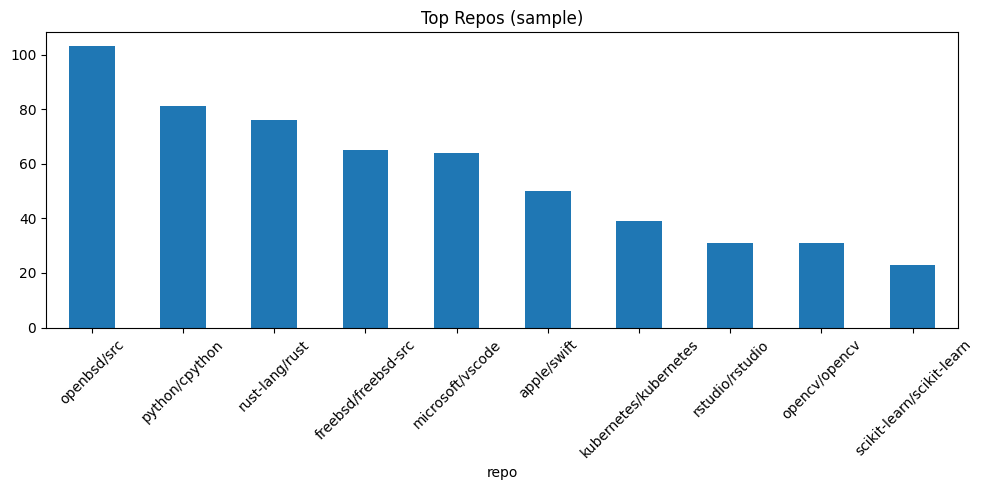

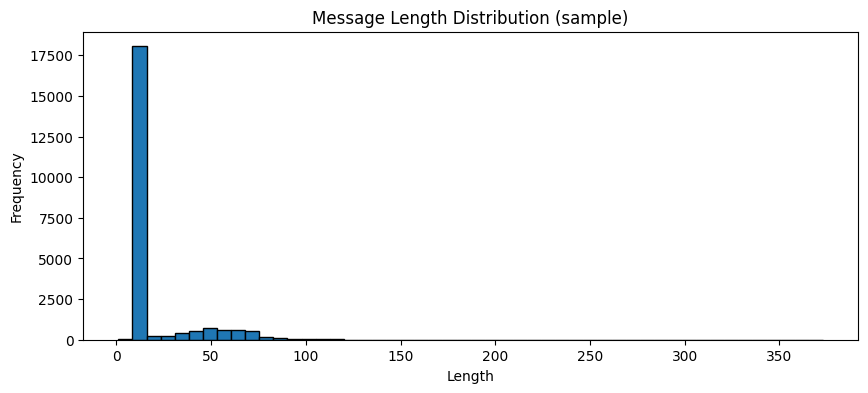

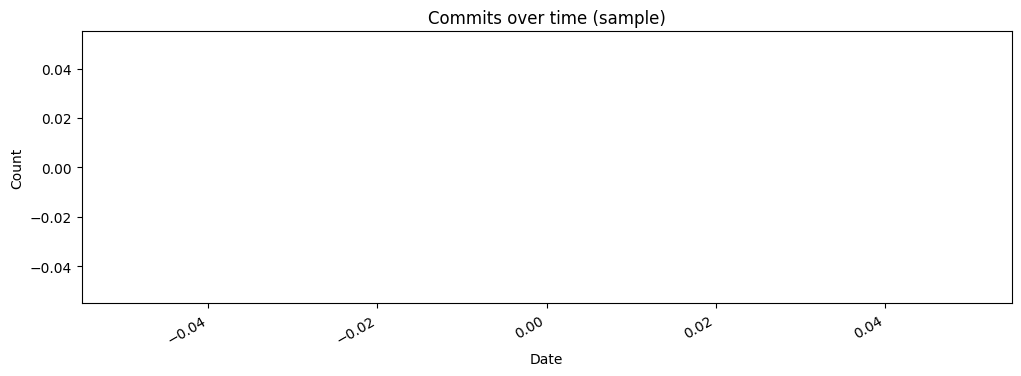

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
top_repo_pdf = pdf['repo'].value_counts().head(10)
plt.figure(figsize=(10,5)); top_repo_pdf.plot(kind='bar'); plt.title('Top Repos (sample)'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4)); plt.hist(pdf['msg_length'].dropna(), bins=50, edgecolor='black'); plt.title('Message Length Distribution (sample)'); plt.xlabel('Length'); plt.ylabel('Frequency'); plt.show()

pdf['date_only'] = pd.to_datetime(pdf['date_parsed']).dt.date
daily = pdf.groupby('date_only').size()
plt.figure(figsize=(12,4)); daily.plot(); plt.title('Commits over time (sample)'); plt.xlabel('Date'); plt.ylabel('Count'); plt.show()

## 15. MLlib pipeline (text classification: long message)

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

median_len = df.approxQuantile("msg_length", [0.5], 0.01)[0]
df_ml = df.withColumn("label", when(col("msg_length") > median_len, 1.0).otherwise(0.0))

tokenizer = Tokenizer(inputCol='message', outputCol='words_token')
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
hash_tf = HashingTF(inputCol='words_clean', outputCol='tf_features', numFeatures=2**16)
idf = IDF(inputCol='tf_features', outputCol='tfidf_features')

author_indexer = StringIndexer(inputCol='author', outputCol='author_idx', handleInvalid='keep')
repo_indexer = StringIndexer(inputCol='repo', outputCol='repo_idx', handleInvalid='keep')

assembler = VectorAssembler(inputCols=['tfidf_features','msg_length_norm','author_idx','repo_idx'], outputCol='features')

lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=20)
pipeline = Pipeline(stages=[tokenizer, remover, hash_tf, idf, author_indexer, repo_indexer, assembler, lr])

train_df, test_df = df_ml.randomSplit([0.8,0.2], seed=42)
print('Train count:', train_df.count(), 'Test count:', test_df.count())

model = pipeline.fit(train_df)

## 16. Evaluate model and sample predictions for confusion matrix

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

pred = model.transform(test_df).select('label','prediction','probability')
bce = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc = bce.evaluate(pred)
mce = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
acc = mce.evaluate(pred)
print('AUC:', auc, 'Accuracy:', acc)

pred_sample = pred.sample(False, 0.01, seed=42).toPandas()
cm_df = pred_sample.groupby(['label','prediction']).size().unstack(fill_value=0)
cm = cm_df.reindex(index=[0.0,1.0], columns=[0.0,1.0], fill_value=0).values

import matplotlib.pyplot as plt
plt.figure(figsize=(5,4)); plt.imshow(cm, cmap='Blues'); plt.title('Confusion Matrix (sample)'); plt.colorbar()
plt.xticks([0,1], ['Pred 0','Pred 1']); plt.yticks([0,1], ['Label 0','Label 1'])
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i,j]), ha='center', va='center', color='white' if cm[i,j] > thresh else 'black')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

## 17. Save model & aggregations (optional)

In [ ]:
model_path = "/content/drive/MyDrive/Responsi_UAS_Big_Data/"
try:
    model.write().overwrite().save(model_path)
    print('Model saved to', model_path)
except Exception as e:
    print('Model save failed:', e)

try:
    repo_counts.toPandas().to_csv('/content/drive/MyDrive/Responsi_UAS_Big_Data/top_repos.csv', index=False)
    top_words.toPandas().to_csv('/content/drive/MyDrive/Responsi_UAS_Big_Data/top_words.csv', index=False)
    print('Aggregations saved to Drive.')
except Exception as e:
    print('Save aggregations failed:', e)

## 18. Stop Spark

In [ ]:
spark.stop()
print('Spark stopped.')